# Кусовая работа студента группы 1365
## Тараданова Николая

### Импорт библиотек, файлов и настройка вывода


In [102]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams.update({'font.size': 14})

import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import plotly.graph_objects as go
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings('ignore')

In [103]:
PATH_TO_TRAIN = 'data/train.csv'
PATH_TO_TEST = 'data/test.csv'

# Использую 3 набора, т.е. разделю тест на тренировочный и тестовые наборы

In [104]:
train_df = pd.read_csv(PATH_TO_TRAIN)

X = train_df.drop(['Price'], axis=1)
y = train_df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

test_df = pd.read_csv(PATH_TO_TEST)


### Используемые функции


In [105]:
def add_columns(dataframe, column_name):
    df = pd.get_dummies(dataframe[column_name])
    for name in df.columns:
        df.rename(columns={name : column_name + '_' + name}, inplace=True)
    dataframe[df.columns] = df
    dataframe.drop([column_name], axis=1, inplace=True)

In [106]:
def display_components_in_cool_3D_space(components, y_train, component1, component2, component3, label='Price'):
    components_with_labels_df = pd.concat([components, y_train], axis=1)
    fig = go.Figure(data=[go.Scatter3d(
        x=components_with_labels_df[component1],
        y=components_with_labels_df[component2],
        z=components_with_labels_df[component3],
        mode='markers',
        marker=dict(
            size=5,
            color=components_with_labels_df[label],
            colorscale='jet',
            colorbar=dict(thickness=10),
            line=dict(width=2, color='DarkSlateGrey')
        )
    )])

    fig.update_layout(
        margin=dict(l=0, r=0, b=0, t=0),
        scene=dict(
            xaxis_title=component1,
            yaxis_title=component2,
            zaxis_title=component3),
    )

    fig.show()

In [107]:
def apply_elbow_method(X):
    distortions = []
    K = range(2,15)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=42).fit(X)
        distortions.append(sum(np.min(cdist(X,
                                            kmeanModel.cluster_centers_,
                                            'euclidean'),
                                      axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 6))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k');

In [108]:
def reduce_dims_to_2D_space_with_PCA(df):
    pca = PCA(n_components=2)
    components = pca.fit_transform(df)
    return pd.DataFrame(data = components, columns = ['component_1', 'component_2'])

def reduce_dims_to_3D_space_with_PCA(df):
    pca = PCA(n_components=3)
    components = pca.fit_transform(df)
    return pd.DataFrame(data = components, columns = ['component_1', 'component_2', 'component_3'])

def reduce_dims_to_2D_space_with_TSNE(df):
    tsne = TSNE(n_components=2, random_state=42)
    components = tsne.fit_transform(df)
    return pd.DataFrame(data = components, columns = ['component_1', 'component_2'])

def reduce_dims_to_3D_space_with_TSNE(df):
    tsne = TSNE(n_components=3, random_state=42)
    components = tsne.fit_transform(df)
    return pd.DataFrame(data = components, columns = ['component_1', 'component_2', 'component_3'])

def display_components_in_3D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, labels], axis=1)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    if labels is not None:
        if labels.nunique() > 10:
            p = ax.scatter(components_with_labels_df['component_1'],
                           components_with_labels_df['component_2'],
                           components_with_labels_df['component_3'],
                           c=labels, cmap=plt.get_cmap('jet'), alpha=0.5)
        else:
            p = ax.scatter(components_with_labels_df['component_1'],
                           components_with_labels_df['component_2'],
                           components_with_labels_df['component_3'],
                           c=labels, cmap=plt.get_cmap('jet', labels.nunique()), alpha=0.5)
    else:
        p = ax.scatter(components_with_labels_df['component_1'],
                       components_with_labels_df['component_2'],
                       components_with_labels_df['component_3'],
                       alpha=0.5)

    ax.set_xlabel('component_1')
    ax.set_ylabel('component_2')
    ax.set_zlabel('component_3')
    ax.set_title('3D mapping of objects')
    fig.colorbar(p);

def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, labels], axis=1)

    if labels is not None:
        if labels.nunique() > 10:
            p = components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2',
                                               c=labels.name, cmap=plt.get_cmap('jet'),
                                               alpha=0.5, figsize=(12, 6), sharex=False)
        else:
            p = components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2',
                                               c=labels.name, cmap=plt.get_cmap('jet', labels.nunique()),
                                               alpha=0.5, figsize=(12, 6), sharex=False)
    else:
        p = components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2',
                                           alpha=0.5, figsize=(12, 6))

    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects');

def display_clusters_distribution(unique_labels, labels_counts):

    plt.figure(figsize=(8,5))

    plt.bar(unique, counts)

    plt.xlabel('Clusters')
    plt.xticks(unique)
    plt.ylabel('Count')
    plt.title('Clusters distribution');

In [109]:
def evaluate_preds(true_values_train, pred_values_train, true_values_test, pred_values_test):
    print('Train:\t' + 'R2 = ' + str(round(r2_score(true_values_train, pred_values_train), 4)) +
          '\tMAE = ' + str(round(mean_absolute_error(true_values_train, pred_values_train), 3)) +
          '\n' +
          'Test:\t' + 'R2 = ' + str(round(r2_score(true_values_test, pred_values_test), 4)) +
          '\tMAE = ' + str(round(mean_absolute_error(true_values_test, pred_values_test), 3))
          )

    plt.figure(figsize=(16, 6))

    plt.subplot(121)
    sns.scatterplot(x=pred_values_train, y=true_values_train)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train: True vs Predicted values');

    plt.subplot(122)
    sns.scatterplot(x=pred_values_test, y=true_values_test)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test: True vs Predicted values');

# Первый взгляд

In [110]:
X_train.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4901,13295,1,1.0,39.248800,NaN,0.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
4375,3756,61,2.0,56.053580,33.929772,8.0,8,12.0,1986,0.300323,B,B,52,10311,6,NaN,1,9,B
6698,15429,13,1.0,41.009788,23.960289,8.0,3,14.0,1997,0.090799,B,B,74,19083,2,NaN,5,15,B
9805,7238,9,2.0,63.640480,58.149243,1.0,3,1.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B
1101,13604,90,1.0,49.327912,20.992250,12.0,15,23.0,2008,0.246032,B,A,22,3151,4,2715.0,3,3,B
9537,2253,1,3.0,89.397275,85.959266,1.0,9,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
7655,7846,79,2.0,42.090330,27.413836,5.0,2,5.0,1964,0.169091,B,B,19,3856,10,NaN,2,5,B
5235,1694,29,2.0,59.031566,36.372927,10.0,20,22.0,2002,0.069660,B,B,31,6119,4,NaN,1,2,B
5165,7897,109,2.0,44.514341,28.068914,5.0,8,9.0,1965,0.000000,B,B,25,5027,4,46.0,1,1,B
118,14822,18,3.0,76.235137,47.001817,10.0,9,17.0,1997,0.000000,B,B,30,5562,0,NaN,0,5,A


In [111]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 4901 to 7270
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             7500 non-null   int64  
 1   DistrictId     7500 non-null   int64  
 2   Rooms          7500 non-null   float64
 3   Square         7500 non-null   float64
 4   LifeSquare     5906 non-null   float64
 5   KitchenSquare  7500 non-null   float64
 6   Floor          7500 non-null   int64  
 7   HouseFloor     7500 non-null   float64
 8   HouseYear      7500 non-null   int64  
 9   Ecology_1      7500 non-null   float64
 10  Ecology_2      7500 non-null   object 
 11  Ecology_3      7500 non-null   object 
 12  Social_1       7500 non-null   int64  
 13  Social_2       7500 non-null   int64  
 14  Social_3       7500 non-null   int64  
 15  Healthcare_1   3886 non-null   float64
 16  Helthcare_2    7500 non-null   int64  
 17  Shops_1        7500 non-null   int64  
 18  Shops

In [112]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,7500.0,8368.529067,4858.185603,0.000000,4165.750000,8378.500000,12540.250000,1.679600e+04
DistrictId,7500.0,50.441733,43.700617,0.000000,19.000000,35.000000,75.000000,2.090000e+02
Rooms,7500.0,1.887600,0.840234,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,7500.0,56.262165,20.337193,2.377248,41.748189,52.539538,65.980391,6.047060e+02
LifeSquare,5906.0,37.438158,98.726068,0.370619,22.838608,32.837997,45.069982,7.480592e+03
KitchenSquare,7500.0,6.417333,32.870226,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,7500.0,8.502800,5.236619,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,7500.0,12.634400,6.833644,0.000000,9.000000,14.000000,17.000000,1.170000e+02
HouseYear,7500.0,4658.735867,231517.756849,1912.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,7500.0,0.117437,0.118195,0.000000,0.017647,0.072158,0.194489,5.218671e-01


#### Посмотрю на целевую переменную

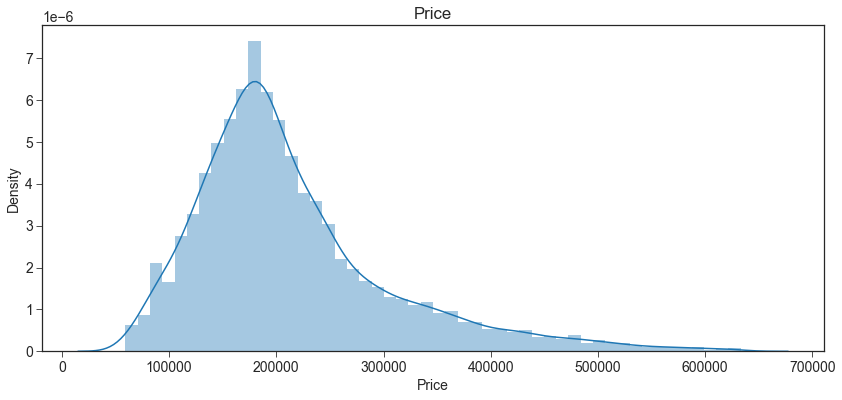

In [113]:
plt.figure(figsize = (14, 6))

sns.distplot(train_df['Price'])
plt.title('Price');

### Фича 'Healthcare' заполнена на 52%, принимаю решение исключить её из набора

In [114]:
X_train.drop(['Healthcare_1'], axis=1, inplace=True)
X_test.drop(['Healthcare_1'], axis=1, inplace=True)
test_df.drop(['Healthcare_1'], axis=1, inplace=True)

### Заполню пропуски по жилой площади

In [115]:
X_train.loc[X_train['LifeSquare'].isna(), 'LifeSquare'] = X_train['Square'] - X_train['KitchenSquare']
X_test.loc[X_test['LifeSquare'].isna(),   'LifeSquare'] = X_test['Square']  - X_test['KitchenSquare']
test_df.loc[test_df['LifeSquare'].isna(), 'LifeSquare'] = test_df['Square'] - test_df['KitchenSquare']

### Выбираю все фичи 'object'

In [116]:
feature_object_names = X_train.select_dtypes(include='object').columns.tolist()
feature_object_names

['Ecology_2', 'Ecology_3', 'Shops_2']

In [117]:
X_train['Ecology_2'].value_counts()

B    7430
A      70
Name: Ecology_2, dtype: int64

In [118]:
X_train['Ecology_3'].value_counts()

B    7289
A     211
Name: Ecology_3, dtype: int64

In [119]:
X_train['Shops_2'].value_counts()

B    6877
A     623
Name: Shops_2, dtype: int64

### Преобразую признаки 'Ecology_2', 'Ecology_3', 'Shops_2' в бинарные

In [120]:
add_columns(X_train, 'Ecology_2')
add_columns(X_train, 'Ecology_3')
add_columns(X_train, 'Shops_2')

add_columns(X_test, 'Ecology_2')
add_columns(X_test, 'Ecology_3')
add_columns(X_test, 'Shops_2')

add_columns(test_df, 'Ecology_2')
add_columns(test_df, 'Ecology_3')
add_columns(test_df, 'Shops_2')


### Посмотрю на числовые фичи

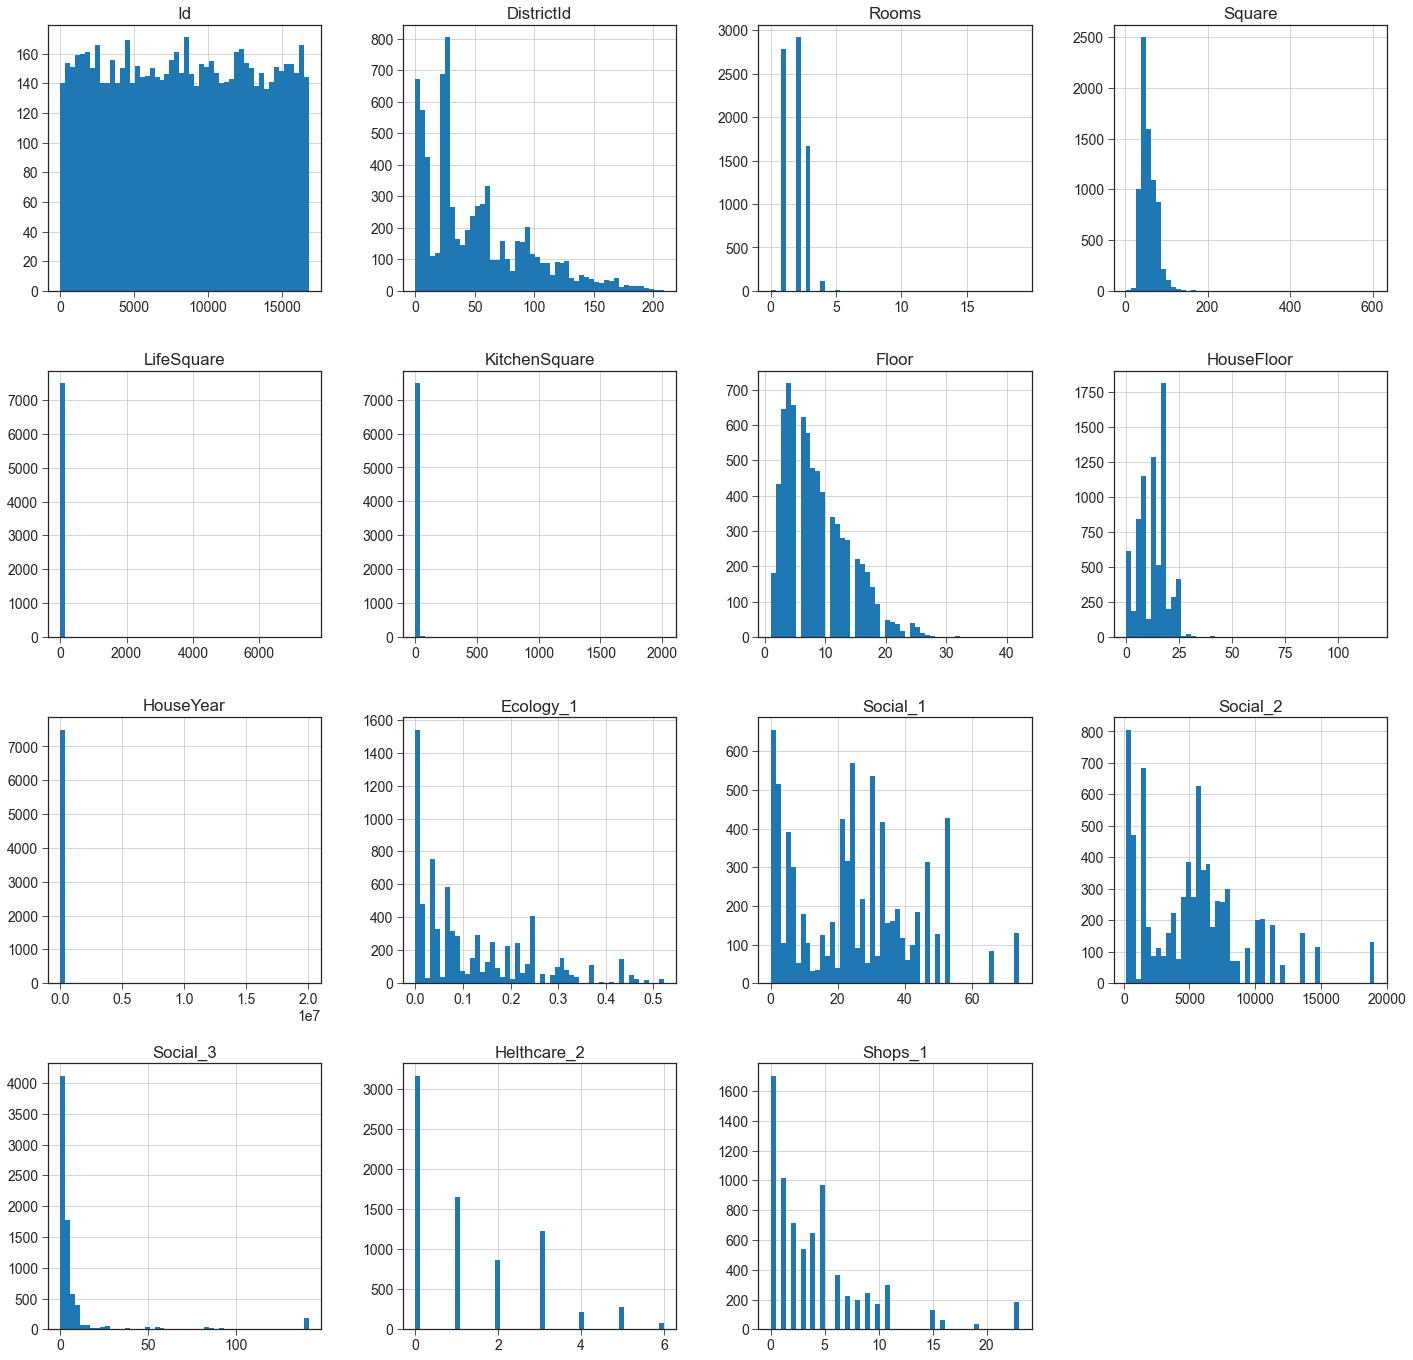

In [121]:
features = X_train.select_dtypes(include=['float64','int64']).columns.tolist()
X_train[features].hist(figsize=(24,24), bins=50, grid=True);

### Для вычислений буду использовать модель GradientBoostingRegressor
Определю значение "локтя", из графика локоть приходится на значение 3, но после нескольких прогонов выяснил, что значение локтя лучше брать равное 8.

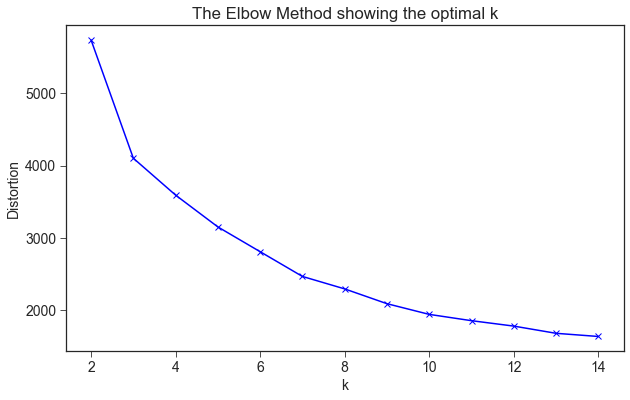

In [122]:
apply_elbow_method(X_train)

#### Стандартизация признаков

In [123]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),
                              columns=X_train.columns,
                              index=X_train.index)

X_test_scaled = pd.DataFrame(scaler.transform(X_test),
                             columns=X_test.columns,
                             index=X_test.index)

test_df_scaled = pd.DataFrame(scaler.transform(test_df),
                             columns=test_df.columns,
                             index=test_df.index)

features = X_train_scaled.iloc[:, :]
features_test = X_test_scaled.iloc[:, :]
features_test_df = test_df_scaled.iloc[:, :]

In [124]:
components_2d_pca = reduce_dims_to_2D_space_with_PCA(features)

### На диаграмме хорошо различаются группы значений, кластеризую данные

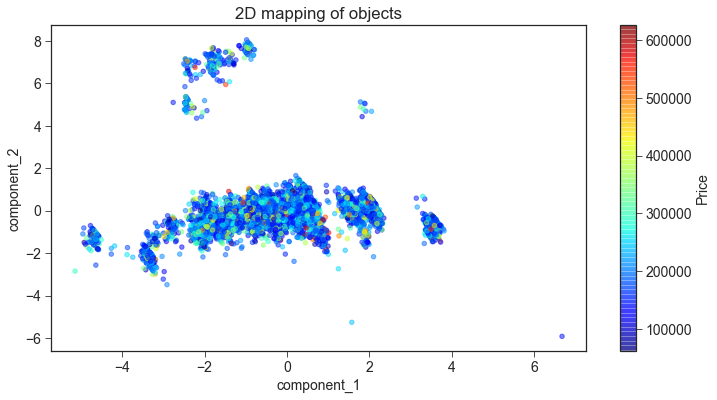

In [125]:
display_components_in_2D_space(components_2d_pca, y_train)

In [126]:
components_3d_pca = reduce_dims_to_3D_space_with_PCA(features)
components_3d_pca_test = reduce_dims_to_3D_space_with_PCA(features_test)

### В 3D группы прослеживаются отчетливее

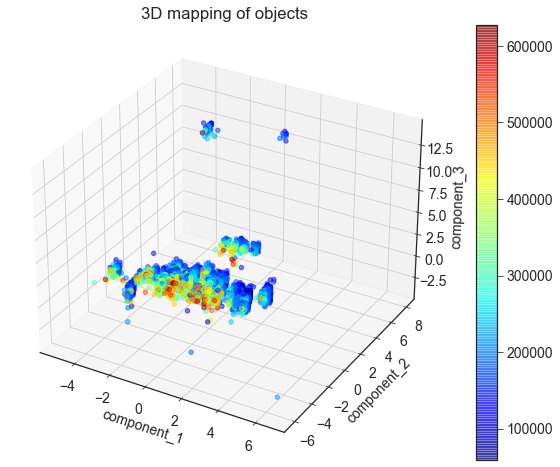

In [127]:
display_components_in_3D_space(components_3d_pca, y_train)

In [128]:
# Красивое, но в DataSpell не отображается)
display_components_in_cool_3D_space(components_3d_pca, y_train,  'component_1', 'component_2', 'component_3')

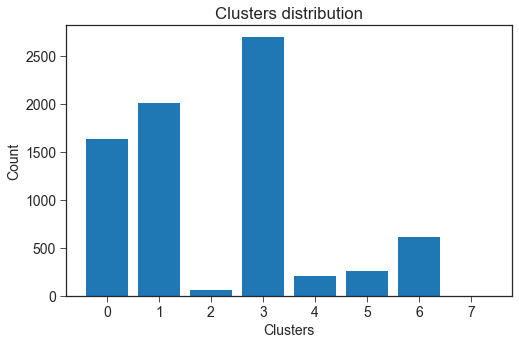

In [129]:
kmeans = KMeans(n_clusters=8, random_state=42)
labels_clast_train = kmeans.fit_predict(features)
labels_clast_train = pd.Series(labels_clast_train, name='clusters')

unique, counts = np.unique(labels_clast_train, return_counts=True)
display_clusters_distribution(unique, counts)

In [130]:
display_components_in_cool_3D_space(components_3d_pca, labels_clast_train, 'component_1', 'component_2', 'component_3', 'clusters')

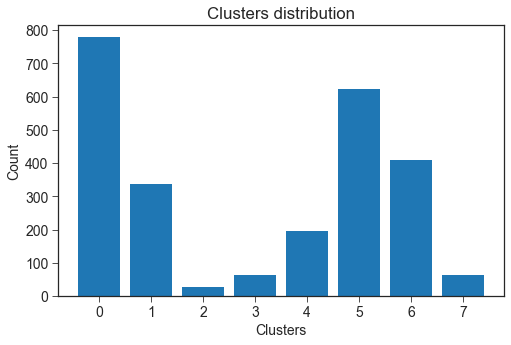

In [131]:
kmeans = KMeans(n_clusters=8, random_state=42)
labels_clast_test = kmeans.fit_predict(features_test)
labels_clast_test = pd.Series(labels_clast_test, name='clusters')

unique, counts = np.unique(labels_clast_test, return_counts=True)
display_clusters_distribution(unique, counts)

### Распределение в тестовом наборе совпадает

In [132]:
display_components_in_cool_3D_space(components_3d_pca_test, labels_clast_test, 'component_1', 'component_2', 'component_3', 'clusters')

In [133]:
kmeans = KMeans(n_clusters=8, random_state=42)
labels_clast_test_df = kmeans.fit_predict(features_test_df)
labels_clast_test_df = pd.Series(labels_clast_test_df, name='clusters')


#### Добавлю новый признак в наборы

In [134]:
X_train_ext = pd.concat([X_train.reset_index(),
                         labels_clast_train], axis=1)
X_train_ext.set_index('index', inplace=True)
X_train_ext.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,clusters
index,,,,,,,,,,,,,,,,,,,,,
4901,13295,1,1.0,39.248800,39.248800,0.0,9,17.0,1977,0.007122,...,0,0,1,0,1,0,1,0,1,1
4375,3756,61,2.0,56.053580,33.929772,8.0,8,12.0,1986,0.300323,...,6,1,9,0,1,0,1,0,1,0
6698,15429,13,1.0,41.009788,23.960289,8.0,3,14.0,1997,0.090799,...,2,5,15,0,1,0,1,0,1,0
9805,7238,9,2.0,63.640480,58.149243,1.0,3,1.0,1977,0.161532,...,1,2,4,0,1,0,1,0,1,3
1101,13604,90,1.0,49.327912,20.992250,12.0,15,23.0,2008,0.246032,...,4,3,3,0,1,1,0,0,1,4
9537,2253,1,3.0,89.397275,85.959266,1.0,9,22.0,1977,0.007122,...,0,0,1,0,1,0,1,0,1,1
7655,7846,79,2.0,42.090330,27.413836,5.0,2,5.0,1964,0.169091,...,10,2,5,0,1,0,1,0,1,3
5235,1694,29,2.0,59.031566,36.372927,10.0,20,22.0,2002,0.069660,...,4,1,2,0,1,0,1,0,1,0
5165,7897,109,2.0,44.514341,28.068914,5.0,8,9.0,1965,0.000000,...,4,1,1,0,1,0,1,0,1,3


In [135]:
X_test_ext = pd.concat([X_test.reset_index(),
                         labels_clast_test], axis=1)
X_test_ext.set_index('index', inplace=True)
X_test_ext.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,clusters
index,,,,,,,,,,,,,,,,,,,,,
6252,3702,21,2.0,48.812195,34.679779,5.0,5,5.0,1963,0.034331,...,3,0,4,0,1,0,1,0,1,0
4684,12848,61,3.0,81.103039,49.310278,8.0,4,4.0,1960,0.298205,...,3,1,3,0,1,0,1,0,1,6
1731,2239,6,3.0,82.882978,3.977650,1.0,8,17.0,1977,0.243205,...,0,0,0,0,1,0,1,0,1,5
4742,15611,23,1.0,33.863324,29.993297,0.0,5,4.0,1977,0.034656,...,0,0,0,0,1,0,1,0,1,5
4521,5634,52,1.0,43.095135,42.095135,1.0,10,17.0,1977,0.371149,...,1,2,5,0,1,0,1,0,1,0
6340,14726,53,3.0,84.569998,60.613297,12.0,18,24.0,2017,0.049637,...,0,1,3,0,1,0,1,0,1,6
576,7247,69,2.0,54.663924,29.266790,9.0,13,17.0,1999,0.000991,...,3,1,9,0,1,0,1,0,1,1
5202,2018,94,1.0,33.521641,30.155171,1.0,17,16.0,2015,0.282798,...,2,0,6,0,1,0,1,0,1,0
6363,14587,6,1.0,40.696294,42.182049,1.0,4,17.0,2014,0.243205,...,0,0,0,0,1,0,1,0,1,5


In [136]:
test_df_ext = pd.concat([test_df.reset_index(),
                        labels_clast_test_df], axis=1)
test_df_ext.set_index('index', inplace=True)
test_df_ext.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,clusters
index,,,,,,,,,,,,,,,,,,,,,
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,1,0,0,0,1,0,1,0,1,2
1,15856,74,2.0,69.263183,68.263183,1.0,6,1.0,1977,0.075779,...,3,0,2,0,1,0,1,0,1,2
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,87,5,5,0,1,0,1,0,1,6
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,3,3,3,0,1,0,1,0,1,1
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,1,0,0,0,1,0,1,1,0,7
5,7633,53,1.0,40.675627,39.675627,1.0,21,21.0,1977,0.049637,...,0,1,3,0,1,0,1,0,1,6
6,13329,23,2.0,68.099538,64.843025,1.0,2,17.0,1977,0.075779,...,3,0,2,0,1,0,1,0,1,2
7,5502,32,2.0,48.193897,32.857644,6.0,5,14.0,1972,0.135650,...,6,3,11,0,1,0,1,0,1,0
8,4220,96,3.0,72.277106,45.968758,9.0,17,17.0,1997,0.041116,...,4,1,4,0,1,0,1,0,1,0


In [137]:
X_train_ext.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,clusters
index,,,,,,,,,,,,,,,,,,,,,
4901,13295,1,1.0,39.248800,39.248800,0.0,9,17.0,1977,0.007122,...,0,0,1,0,1,0,1,0,1,1
4375,3756,61,2.0,56.053580,33.929772,8.0,8,12.0,1986,0.300323,...,6,1,9,0,1,0,1,0,1,0
6698,15429,13,1.0,41.009788,23.960289,8.0,3,14.0,1997,0.090799,...,2,5,15,0,1,0,1,0,1,0
9805,7238,9,2.0,63.640480,58.149243,1.0,3,1.0,1977,0.161532,...,1,2,4,0,1,0,1,0,1,3
1101,13604,90,1.0,49.327912,20.992250,12.0,15,23.0,2008,0.246032,...,4,3,3,0,1,1,0,0,1,4


In [138]:
X_train_ext.shape, X_test_ext.shape, test_df_ext.shape

((7500, 22), (2500, 22), (5000, 22))

In [139]:
X_train_ext.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,clusters
index,,,,,,,,,,,,,,,,,,,,,
4901,13295,1,1.0,39.248800,39.248800,0.0,9,17.0,1977,0.007122,...,0,0,1,0,1,0,1,0,1,1
4375,3756,61,2.0,56.053580,33.929772,8.0,8,12.0,1986,0.300323,...,6,1,9,0,1,0,1,0,1,0
6698,15429,13,1.0,41.009788,23.960289,8.0,3,14.0,1997,0.090799,...,2,5,15,0,1,0,1,0,1,0
9805,7238,9,2.0,63.640480,58.149243,1.0,3,1.0,1977,0.161532,...,1,2,4,0,1,0,1,0,1,3
1101,13604,90,1.0,49.327912,20.992250,12.0,15,23.0,2008,0.246032,...,4,3,3,0,1,1,0,0,1,4


In [140]:
X_test_ext.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,clusters
index,,,,,,,,,,,,,,,,,,,,,
6252,3702,21,2.0,48.812195,34.679779,5.0,5,5.0,1963,0.034331,...,3,0,4,0,1,0,1,0,1,0
4684,12848,61,3.0,81.103039,49.310278,8.0,4,4.0,1960,0.298205,...,3,1,3,0,1,0,1,0,1,6
1731,2239,6,3.0,82.882978,3.977650,1.0,8,17.0,1977,0.243205,...,0,0,0,0,1,0,1,0,1,5
4742,15611,23,1.0,33.863324,29.993297,0.0,5,4.0,1977,0.034656,...,0,0,0,0,1,0,1,0,1,5
4521,5634,52,1.0,43.095135,42.095135,1.0,10,17.0,1977,0.371149,...,1,2,5,0,1,0,1,0,1,0


#### Подбор параметров дал параметры n_estimators=90, max_depth=6, max_features=13
Эта часть стала для меня самой сложной в плане понимания, потому что при max_features=9 R2 выше, хотя RFV выдает 13, и я не понимаю почему

Train:	R2 = 0.8866	MAE = 20283.616
Test:	R2 = 0.7304	MAE = 29376.009


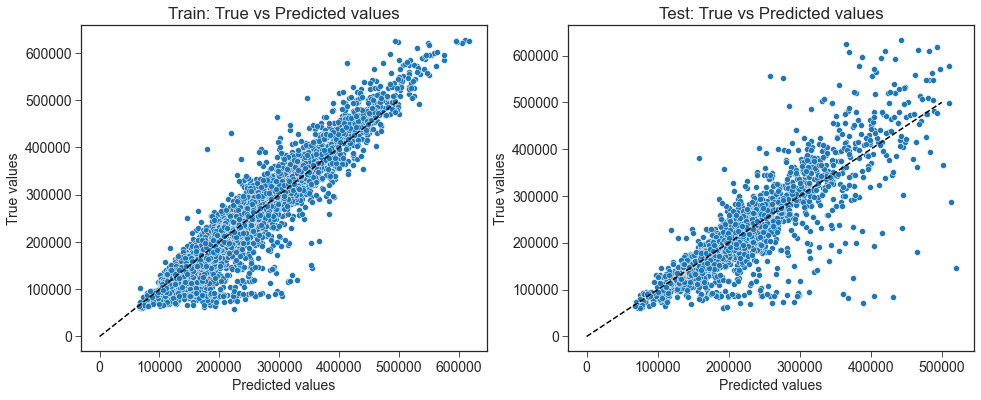

In [141]:
gb_model = GradientBoostingRegressor(n_estimators=90, max_depth=6, max_features=9,  random_state=42)

gb_model.fit(X_train_ext, y_train)
y_train_preds = gb_model.predict(X_train_ext)
y_test_preds = gb_model.predict(X_test_ext)
evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

#### Подбор параметров


In [142]:
# params = {
#     #    'n_estimators': [100],
#     'n_estimators': [90, 100, 110],
#     'max_depth': [5, 6, 7]
# }
# forest_grid = GridSearchCV(gb_model, params, scoring='r2',
#                            cv=KFold(n_splits=5, random_state=42, shuffle=True),
#                            n_jobs=-1)
#
# forest_grid.fit(X_train_ext, y_train)
# print(forest_grid.best_params_)
# print('R2 на train: {:.5f}'.format(forest_grid.best_score_))
#
# # {'max_depth': 6, 'n_estimators': 100

In [143]:
# feature_names_full = [feature for feature in X_train_ext.columns if feature not in ['Price']]
# rfe = RFE(estimator=gb_model,
#           n_features_to_select=13,
#           step=2)
#
# rfe.fit(X_train_ext, y_train)
# X_train_ext.columns[rfe.support_]
# X_new = rfe.transform(X_train_ext)
# scores = cross_val_score(gb_model, X_new, y_train, scoring='r2', cv=KFold(n_splits=5, random_state=42, shuffle=True))
# print('R2: %.5f' % scores.mean())

In [144]:
# for n in range(9, 15, 1):
#     rfe = RFE(gb_model, n_features_to_select=n, step=2)
#     X_new = rfe.fit_transform(X_train_ext, y_train)
#     scores = cross_val_score(gb_model, X_new, y_train, scoring='r2', cv=KFold(n_splits=5, random_state=42, shuffle=True))
#     print('n_features_to_select: {} - R2: {:.5}'.format(n, scores.mean()))

### Прогнозирование на тестовом датасете

In [145]:
test_df_ext.shape, X_train_ext.shape

((5000, 22), (7500, 22))

In [146]:
gb_model.fit(X_train_ext, y_train)
y_pred = gb_model.predict(test_df_ext)
y_pred

array([169370.40731126, 220353.30889701, 159638.02314065, ...,
       335155.54407466, 197382.06525833, 193620.75780289])

In [147]:

preds_final = pd.DataFrame()
preds_final['Id'] = X_test['Id'].copy()

X_test.set_index('Id', inplace=True)

submission_df = pd.read_csv('data/sample_submission.csv')

submission_df['Price'] = y_pred
submission_df.to_csv('./TaradanovNV_predictions_1365.csv', index=False, encoding='utf-8', sep=',')

submission_df.head()

,Id,Price
0,725,169370.407311
1,15856,220353.308897
2,5480,159638.023141
3,15664,369758.768384
4,14275,137595.078841


In [148]:

# preds.to_csv('submission_16.csv', index=False)